## 3. Classification of Questionnaire Responses

In this section, we will use BERT to classify the responses into Low Risk, Moderate Risk, and High Risk categories. We will use the `transformers` library to load a pre-trained BERT model and fine-tune it on our dataset.

In [1]:
%mkdir models

In [2]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


## 3.1 Fine Tuning with BERT

In this section, we will explore the use of BERT for classification on our dataset. To allow us to perform fine-tuning on BERT, we will make use of

### 3.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train 3 different BERT models on fatigue, lifestyle as well as mental health.

In [4]:
# Create labels for each column
def label_responses(df):
    # Copy the dataframe to avoid modifying the original
    df_label = df.copy()

    # Fatigue level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['fatigue_label'] = df_label['fatigue_level'].apply(
        lambda x: 'Low Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'High Risk')
    )

    # Mental health level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['mental_health_label'] = df_label['mental_health_level'].apply(
        lambda x: 'High Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'Low Risk')
    )

    return df_label

# Apply the labeling
df_with_label = label_responses(df)

# Display the original values and the new labels
display(df_with_label[['fatigue_level', 'fatigue_label',
                          'mental_health_level', 'mental_health_label']].head(10))

# Count the label distributions for each category
print("\nFatigue Label Distribution:")
print(df_with_label['fatigue_label'].value_counts())

print("\nMental Health Label Distribution:")
print(df_with_label['mental_health_label'].value_counts())

,fatigue_level,fatigue_label,mental_health_level,mental_health_label
0,5,High Risk,1,High Risk
1,2,Low Risk,4,Low Risk
2,5,High Risk,1,High Risk
3,1,Low Risk,4,Low Risk
4,3,Moderate Risk,3,Moderate Risk
5,4,High Risk,1,High Risk
6,1,Low Risk,5,Low Risk
7,5,High Risk,1,High Risk
8,2,Low Risk,3,Moderate Risk
9,4,High Risk,1,High Risk



Fatigue Label Distribution:
fatigue_label
Low Risk         513
High Risk        508
Moderate Risk    182
Name: count, dtype: int64

Mental Health Label Distribution:
mental_health_label
High Risk        571
Low Risk         460
Moderate Risk    172
Name: count, dtype: int64


In [6]:
# construcut labelled dataset
df_label = df_with_label[['fatigue_label', 'mental_health_label']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_label['describe_fatigue_level'] = df['describe_fatigue_level']
df_label['describe_mental_health'] = df['describe_mental_health']

# preview the labelled dataset
display(df_label.head(n=10))

,fatigue_label,mental_health_label,describe_fatigue_level,describe_mental_health
0,High Risk,High Risk,"Severe fatigue, difficulty getting out of bed.",Feeling anxious and low.
1,Low Risk,Low Risk,Mild fatigue occasionally.,Generally good.
2,High Risk,High Risk,Constant exhaustion.,Feeling down and worried.
3,Low Risk,Low Risk,Not fatigued.,Good.
4,Moderate Risk,Moderate Risk,Moderate fatigue after work.,Stable.
5,High Risk,High Risk,Fatigued most of the time.,Struggling with memory and mood.
6,Low Risk,Low Risk,Not fatigued.,Excellent.
7,High Risk,High Risk,"Severely fatigued, breathless with minimal eff...",Anxious and weak.
8,Low Risk,Moderate Risk,Occasional fatigue.,Manages anxiety well.
9,High Risk,High Risk,Significant fatigue and joint pain.,Frustrated and low due to pain.


We can see that the data is being properly prepared to be used for training and testing.

### 3.1.2 Model Training

In this section we will train 2 separate BERT models on A100 GPU.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
!nvidia-smi

Sat May 24 04:20:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'Low Risk': 0, 'Moderate Risk': 1, 'High Risk': 2}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=40):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase for each epoch
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Return the model and evaluation results
    return model, true_labels, predictions, train_losses, val_losses

# Function to run classification of questionnaire responses for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Classification of Questionnaire Responses Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_qr_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

fatigue_model, fatigue_name, fatigue_true, fatigue_pred, fatigue_train_loss, fatigue_val_loss = analyze_sentiment(
    df_label,
    'describe_fatigue_level',
    'fatigue_label',
    'Fatigue'
)
eval_results['Fatigue'] = (fatigue_true, fatigue_pred)
loss_history['Fatigue'] = (fatigue_train_loss, fatigue_val_loss)

mental_health_model, mental_health_name, mental_health_true, mental_health_pred, mental_health_train_loss, mental_health_val_loss = analyze_sentiment(
    df_label,
    'describe_mental_health',
    'mental_health_label',
    'Mental Health'
)
eval_results['Mental Health'] = (mental_health_true, mental_health_pred)
loss_history['Mental Health'] = (mental_health_train_loss, mental_health_val_loss)


=== Training All Sentiment Analysis Models ===


--- Fatigue Classification of Questionnaire Responses Training ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40


Training (loss=0.2752): 100%|██████████| 60/60 [00:06<00:00,  9.95it/s]


Training loss: 0.7285


Validation: 100%|██████████| 15/15 [00:00<00:00, 35.27it/s]


Validation loss: 0.3257
Epoch 2/40


Training (loss=0.1452): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.2608


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.2423
Epoch 3/40


Training (loss=0.2732): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.1900


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.2118
Epoch 4/40


Training (loss=0.0576): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.1667


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.71it/s]


Validation loss: 0.2245
Epoch 5/40


Training (loss=0.0214): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.1241


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.78it/s]


Validation loss: 0.2577
Epoch 6/40


Training (loss=0.0122): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.1013


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.3053
Epoch 7/40


Training (loss=0.1940): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0887


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.96it/s]


Validation loss: 0.2849
Epoch 8/40


Training (loss=0.0096): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0989


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.2822
Epoch 9/40


Training (loss=0.0136): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0829


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.81it/s]


Validation loss: 0.3176
Epoch 10/40


Training (loss=0.3640): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0716


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3216
Epoch 11/40


Training (loss=0.2148): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0710


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.3244
Epoch 12/40


Training (loss=0.0428): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0896


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.2781
Epoch 13/40


Training (loss=0.2611): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0758


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.3252
Epoch 14/40


Training (loss=0.0165): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0521


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.84it/s]


Validation loss: 0.3571
Epoch 15/40


Training (loss=0.0484): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0562


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.83it/s]


Validation loss: 0.3701
Epoch 16/40


Training (loss=0.3381): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0565


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3665
Epoch 17/40


Training (loss=0.0138): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0495


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.3331
Epoch 18/40


Training (loss=0.0030): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0502


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.82it/s]


Validation loss: 0.3503
Epoch 19/40


Training (loss=0.0119): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0443


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.3808
Epoch 20/40


Training (loss=0.1590): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0472


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.4104
Epoch 21/40


Training (loss=0.0173): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0508


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.73it/s]


Validation loss: 0.4406
Epoch 22/40


Training (loss=0.0427): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0755


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.78it/s]


Validation loss: 0.3553
Epoch 23/40


Training (loss=0.1502): 100%|██████████| 60/60 [00:05<00:00, 11.94it/s]


Training loss: 0.0583


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.80it/s]


Validation loss: 0.4388
Epoch 24/40


Training (loss=0.0040): 100%|██████████| 60/60 [00:04<00:00, 12.03it/s]


Training loss: 0.0488


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.4148
Epoch 25/40


Training (loss=0.2232): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0609


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.3009
Epoch 26/40


Training (loss=0.0135): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0456


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.88it/s]


Validation loss: 0.3551
Epoch 27/40


Training (loss=0.0689): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0424


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3807
Epoch 28/40


Training (loss=0.0221): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0372


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.81it/s]


Validation loss: 0.3861
Epoch 29/40


Training (loss=0.0063): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0376


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.96it/s]


Validation loss: 0.4058
Epoch 30/40


Training (loss=0.0097): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0375


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.4164
Epoch 31/40


Training (loss=0.1179): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0389


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3980
Epoch 32/40


Training (loss=0.0082): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0475


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.85it/s]


Validation loss: 0.3982
Epoch 33/40


Training (loss=0.0617): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0444


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.90it/s]


Validation loss: 0.4099
Epoch 34/40


Training (loss=0.0871): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0549


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.4085
Epoch 35/40


Training (loss=0.0043): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0567


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.87it/s]


Validation loss: 0.4039
Epoch 36/40


Training (loss=0.0008): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0477


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.74it/s]


Validation loss: 0.4172
Epoch 37/40


Training (loss=0.0411): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0415


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.90it/s]


Validation loss: 0.4435
Epoch 38/40


Training (loss=0.0292): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0421


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.83it/s]


Validation loss: 0.3875
Epoch 39/40


Training (loss=0.0032): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0362


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.01it/s]


Validation loss: 0.3910
Epoch 40/40


Training (loss=0.0005): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0347


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.88it/s]


Validation loss: 0.4137


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.98it/s]


Validation loss: 0.4137
Model saved to models/bert_qr_fatigue

--- Mental Health Classification of Questionnaire Responses Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40


Training (loss=0.0872): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.5799


Validation: 100%|██████████| 16/16 [00:00<00:00, 37.12it/s]


Validation loss: 0.3637
Epoch 2/40


Training (loss=0.0948): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.2677


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.2731
Epoch 3/40


Training (loss=0.8906): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.2048


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.51it/s]


Validation loss: 0.2782
Epoch 4/40


Training (loss=0.0741): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1650


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.2994
Epoch 5/40


Training (loss=1.1809): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.1470


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.21it/s]


Validation loss: 0.3457
Epoch 6/40


Training (loss=0.0134): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1296


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation loss: 0.4303
Epoch 7/40


Training (loss=0.0151): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.1023


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation loss: 0.4952
Epoch 8/40


Training (loss=0.0089): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1127


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.38it/s]


Validation loss: 0.5472
Epoch 9/40


Training (loss=0.0068): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.1094


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.5690
Epoch 10/40


Training (loss=0.0066): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0879


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]


Validation loss: 0.6077
Epoch 11/40


Training (loss=0.0119): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0892


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


Validation loss: 0.5839
Epoch 12/40


Training (loss=0.0015): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0842


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation loss: 0.6403
Epoch 13/40


Training (loss=0.0015): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0860


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation loss: 0.6462
Epoch 14/40


Training (loss=0.0012): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0869


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.58it/s]


Validation loss: 0.6164
Epoch 15/40


Training (loss=0.0009): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0827


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation loss: 0.6130
Epoch 16/40


Training (loss=0.0077): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0745


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation loss: 0.6903
Epoch 17/40


Training (loss=0.0012): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0721


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Validation loss: 0.6323
Epoch 18/40


Training (loss=0.0041): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0701


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.6559
Epoch 19/40


Training (loss=0.0005): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0739


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.6036
Epoch 20/40


Training (loss=0.0054): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0800


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.6297
Epoch 21/40


Training (loss=0.0090): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0763


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation loss: 0.6892
Epoch 22/40


Training (loss=0.0506): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0786


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation loss: 0.6870
Epoch 23/40


Training (loss=0.0016): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0737


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.58it/s]


Validation loss: 0.7371
Epoch 24/40


Training (loss=0.0192): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0685


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.6551
Epoch 25/40


Training (loss=0.0017): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0673


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.65it/s]


Validation loss: 0.6730
Epoch 26/40


Training (loss=0.2638): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0677


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.7708
Epoch 27/40


Training (loss=0.0010): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0692


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation loss: 0.7489
Epoch 28/40


Training (loss=0.0250): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0690


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.7920
Epoch 29/40


Training (loss=0.0142): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0671


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.51it/s]


Validation loss: 0.7522
Epoch 30/40


Training (loss=0.0016): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.1036


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.63it/s]


Validation loss: 0.5638
Epoch 31/40


Training (loss=0.1554): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0883


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.44it/s]


Validation loss: 0.7174
Epoch 32/40


Training (loss=0.0021): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0754


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation loss: 0.8133
Epoch 33/40


Training (loss=0.0498): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0883


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.27it/s]


Validation loss: 0.6749
Epoch 34/40


Training (loss=0.0006): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0774


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation loss: 0.7309
Epoch 35/40


Training (loss=0.0099): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.1141


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.30it/s]


Validation loss: 0.4260
Epoch 36/40


Training (loss=0.0129): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0893


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


Validation loss: 0.7446
Epoch 37/40


Training (loss=0.0186): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0819


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.40it/s]


Validation loss: 0.7673
Epoch 38/40


Training (loss=0.0105): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0935


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.7480
Epoch 39/40


Training (loss=0.0004): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0707


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.8126
Epoch 40/40


Training (loss=0.0062): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0650


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation loss: 0.8540


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation loss: 0.8540
Model saved to models/bert_qr_mental_health


Fatigue model - Best epoch: 3 with validation loss: 0.2118
Mental Health model - Best epoch: 2 with validation loss: 0.2731


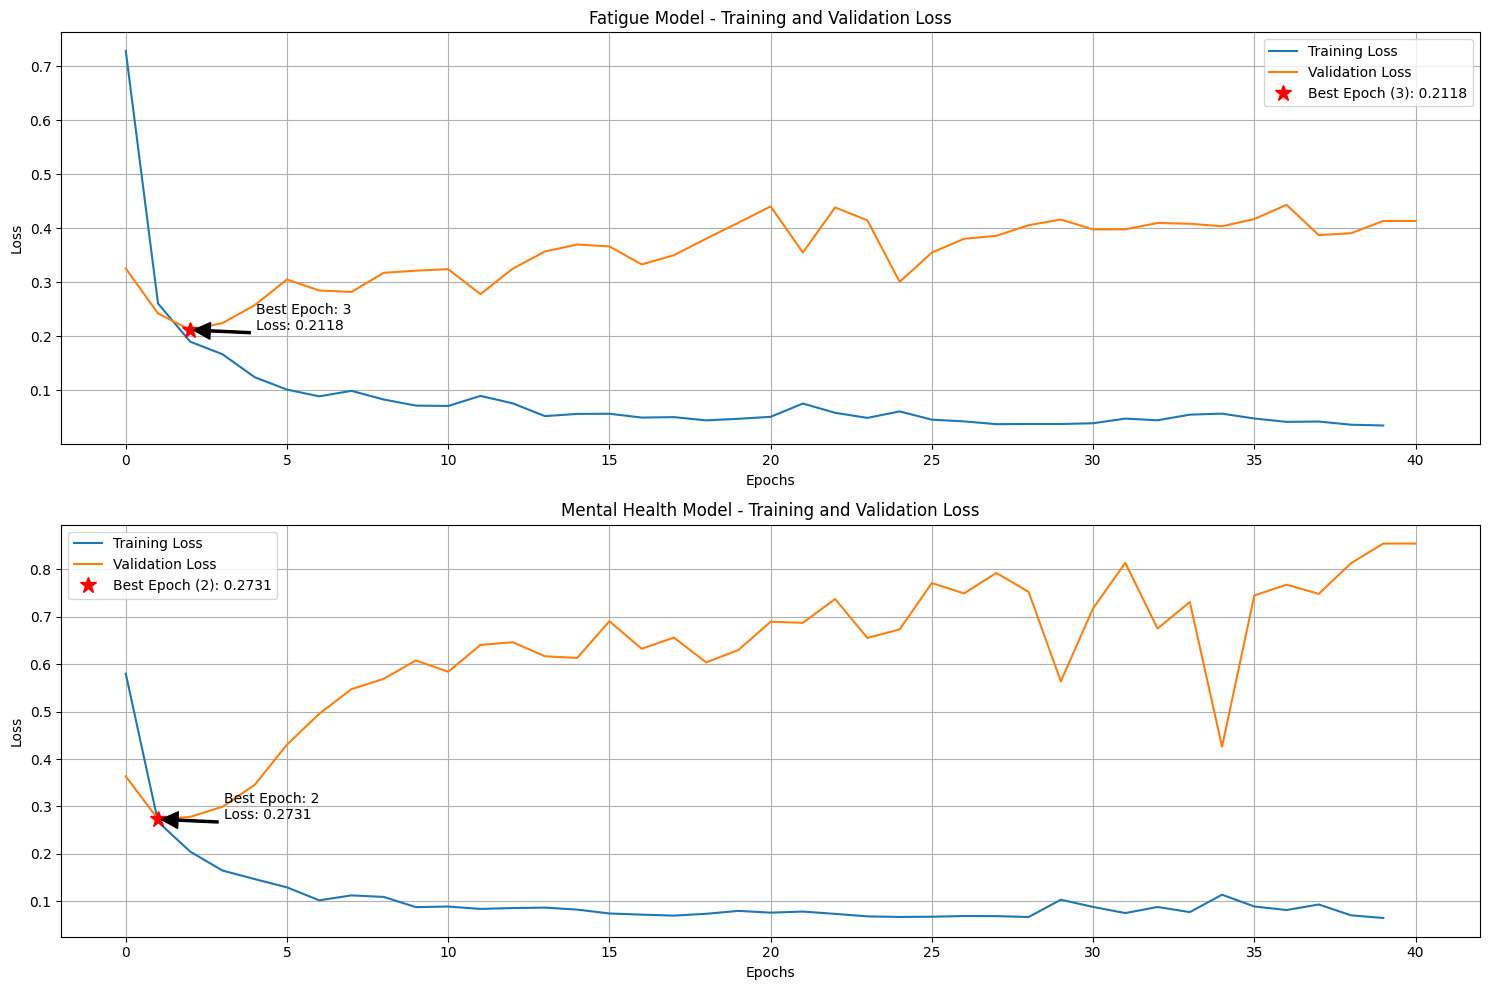

In [11]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/qr_loss_curves_with_best_epoch.png')
plt.show()

In [12]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS")
print("="*70)

label_names = ['Low Risk', 'Moderate Risk', 'High Risk']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/qr_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS

Fatigue Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.98      0.91      0.94       103
Moderate Risk       0.76      0.80      0.78        35
    High Risk       0.94      0.99      0.97       102

     accuracy                           0.93       240
    macro avg       0.89      0.90      0.90       240
 weighted avg       0.93      0.93      0.93       240




Mental Health Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.85      0.92      0.89        92
Moderate Risk       0.69      0.51      0.59        35
    High Risk       0.96      0.96      0.96       114

     accuracy                           0.88       241
    macro avg       0.83      0.80      0.81       241
 weighted avg       0.88      0.88      0.88       241





In [13]:
# zip the models directory
!zip -r models.zip models
!zip -r images.zip images

# download from colab
from google.colab import files
files.download('models.zip')

  adding: models/ (stored 0%)
  adding: models/qr_eval_results.pkl (deflated 96%)
  adding: models/bert_qr_fatigue/ (stored 0%)
  adding: models/bert_qr_fatigue/model.safetensors (deflated 7%)
  adding: models/bert_qr_fatigue/config.json (deflated 51%)
  adding: models/bert_qr_mental_health/ (stored 0%)
  adding: models/bert_qr_mental_health/model.safetensors (deflated 7%)
  adding: models/bert_qr_mental_health/config.json (deflated 51%)
  adding: images/ (stored 0%)
  adding: images/qr_loss_curves_with_best_epoch.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>